#Explores impact of Feature Reduction and Scoring on result

In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import warnings


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.ensemble
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import SGDClassifier

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

import sys
sys.path.append('../dev')
from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

from ml_plot import getClassifierProbs
from ml_plot import plotThresholdDistribuition, plotPredictionStats
from ml_plot import plotCombinedResults

from ml_plot import PredictCV_TrainTest

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression, f_classif

# Configuration

In [3]:
PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
# PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

# SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
SCORING = 'roc_auc'

JOBS = 4
VERBOSE = 0

In [4]:
warnings.filterwarnings("ignore", 'F-score is ill-defined')
warnings.filterwarnings("ignore", 'RuntimeWarning: invalid value encountered in divide')

# Load Data

In [9]:
%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

In [10]:
scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

In [11]:
n_feats = 500
newX = SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y)

/Users/doug/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:161: RuntimeWarning: invalid value encountered in divide
  chisq /= f_exp


### Select Split Strategy

In [12]:
cv = PredictCV(len(Y), history=2000, future=500, n_iter=10, seed=87654321)

# Initial Calibration of Logistic Regression Settings

In [13]:
estimator = LogisticRegression()

In [14]:
C_range = np.logspace(-2, 2, 9)
param_grid = dict(C=C_range, class_weight=['auto'])

In [15]:
if False:
    for SCORING in ['f1','accuracy', 'precision', 'recall', 'average_precision', 'roc_auc']:
        print 'Scoring:', SCORING
        grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                        n_jobs=1, pre_dispatch=1, verbose=VERBOSE)
        grid.fit(newX, Y)
        print 'best_score: ', grid.best_score_, 'using scoring:', SCORING
        clf = grid.best_estimator_
        print grid.best_estimator_

        eval_predictions(grid.best_estimator_, newX, Y, n_iter=100,
                         history_sizes=[2000], future_sizes=[500],
                         seed=12345678)
    
        print
        sys.stdout.flush()

Scoring: f1
best_score:  0.453947113995 using scoring: f1
LogisticRegression(C=0.31622776601683794, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)
** Predictions for hist=2000 future=500 **

F1:        0.49  +/- 0.08
Accuracy:  0.75  +/- 0.02
Precision: 0.41  +/- 0.10
Recall:    0.61  +/- 0.06

Aggregate Confusion Matrix - 100 iterations
[[30853  8719]
 [ 4003  6425]]



Scoring: accuracy
best_score:  0.7664 using scoring: accuracy
LogisticRegression(C=31.622776601683793, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)
** Predictions for hist=2000 future=500 **

F1:        0.46  +/- 0.06
Accuracy:  0.74  +/- 0.03
Precision: 0.40  +/- 0.08
Recall:    0.55  +/- 0

#Look at LR classifier performance as a function of C

c: 0.01
* * * * * * * * * *
c: 0.03666
* * * * * * * * * *
c: 0.1
* * * * * * * * * *
c: 0.3666
* * * * * * * * * *
c: 1.0
* * * * * * * * * *


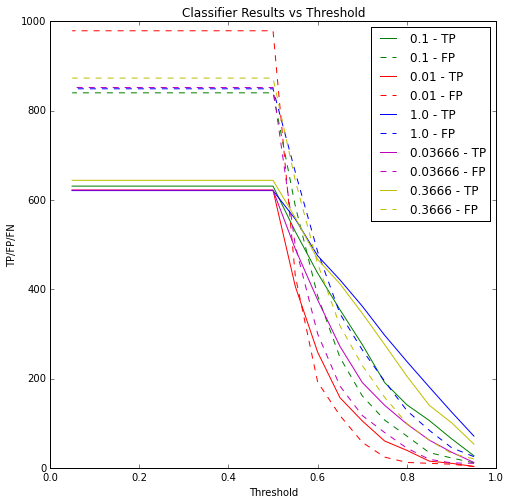

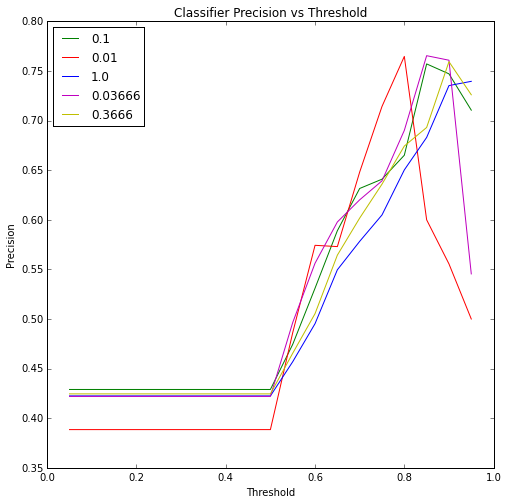

In [56]:
all_results = {}
n_feats = 500

for c in [0.01, 0.03666, 0.1, 0.3666, 1.0]:
    print 'c:', c
    clf = LogisticRegression(C=c, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results['{}'.format(c)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

c: 1.0
* * * * * * * * * *
c: 3.666
* * * * * * * * * *
c: 10.0
* * * * * * * * * *
c: 36.66
* * * * * * * * * *
c: 100.0
* * * * * * * * * *


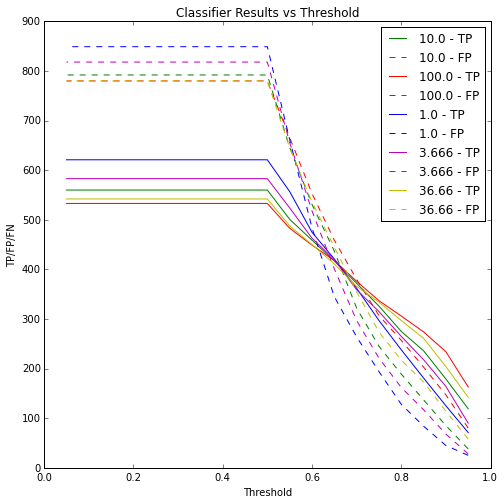

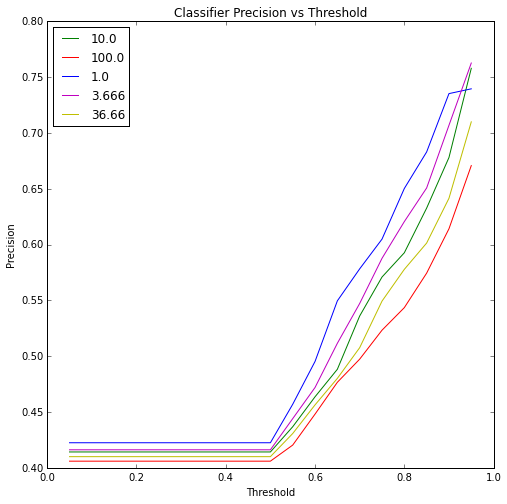

In [57]:
all_results = {}
n_feats = 500

for c in [1.0, 3.666, 10.0, 36.66, 100.0]:
    print 'c:', c
    clf = LogisticRegression(C=c, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results['{}'.format(c)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

#Now look at impact of Feature Reduction

In [58]:
clf = LogisticRegression(C=0.31622776601683794, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

n_feats: 50
* * * * * * * * * *
n_feats: 100
* * * * * * * * * *
n_feats: 200
* * * * * * * * * *
n_feats: 300
* * * * * * * * * *
n_feats: 400
* * * * * * * * * *
n_feats: 500
* * * * * * * * * *


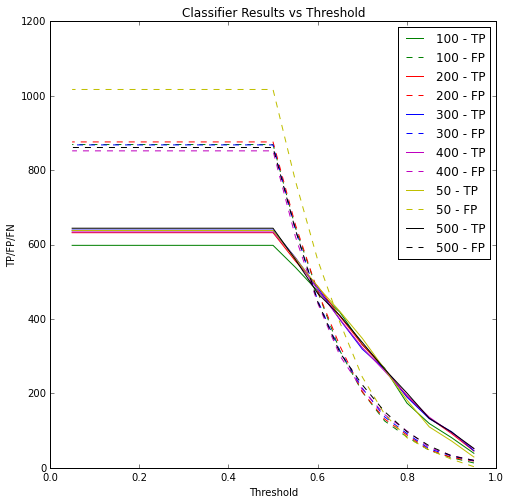

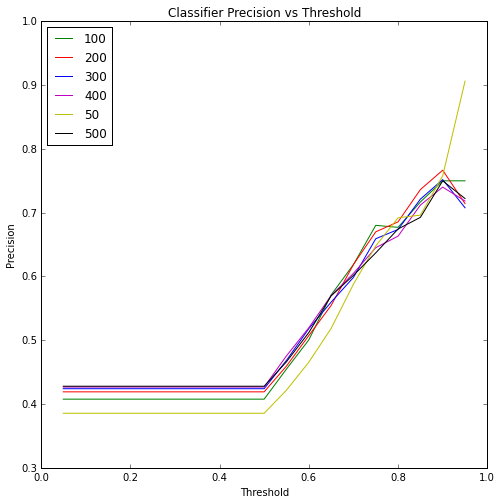

In [59]:
all_results = {}

for n_feats in [50, 100, 200, 300, 400, 500]:
    print 'n_feats:', n_feats
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results[n_feats] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

n_feats: 500
* * * * * * * * * *
n_feats: 700
* * * * * * * * * *
n_feats: 1000
* * * * * * * * * *
n_feats: 1500
* * * * * * * * * *
n_feats: 2000
* * * * * * * * * *


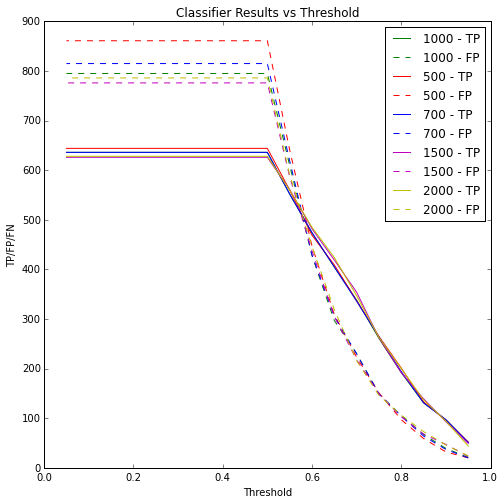

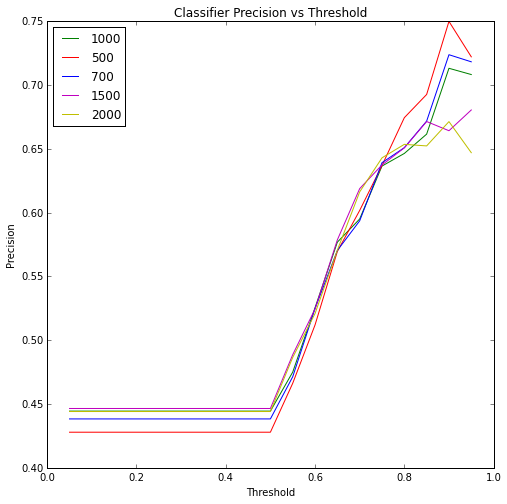

In [60]:
all_results = {}

for n_feats in [500, 700, 1000, 1500, 2000]:
    print 'n_feats:', n_feats
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results[n_feats] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

Increased feature count improves false-positive rate (lower)

#Try Again with Adaboost

In [62]:
clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=25, random_state=None)

###Look at impact of number of estimators

n_est: 15
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_est: 20
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_est: 25
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_est: 30
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_est: 35
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

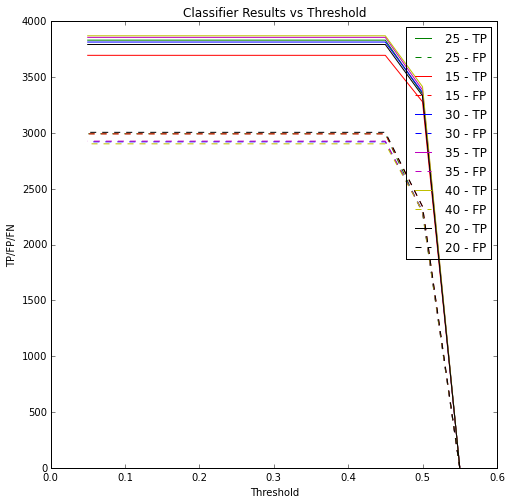

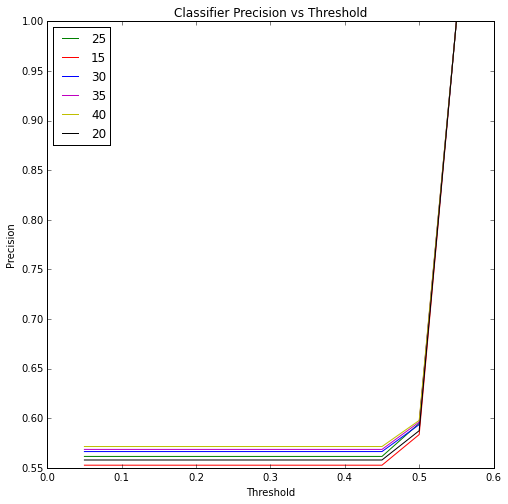

In [63]:
all_results = {}
n_feats = 500

for n_est in [15, 20, 25, 30, 35, 40]:
    print 'n_est:', n_est
    clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME',
                                              base_estimator=None, learning_rate=1.0,
                                              n_estimators=n_est, random_state=None)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=100, seed=12345678)
    all_results['{}'.format(n_est)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

40 looks like the best precision

###Look at learning rate

lr: 0.6
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
lr: 0.8
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
lr: 1.0
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
lr: 1.2
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
lr: 1.4
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

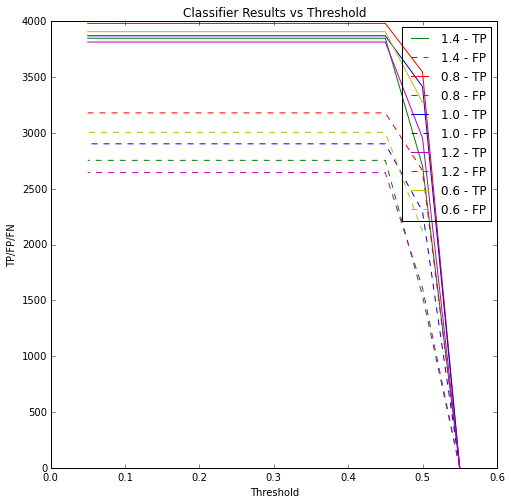

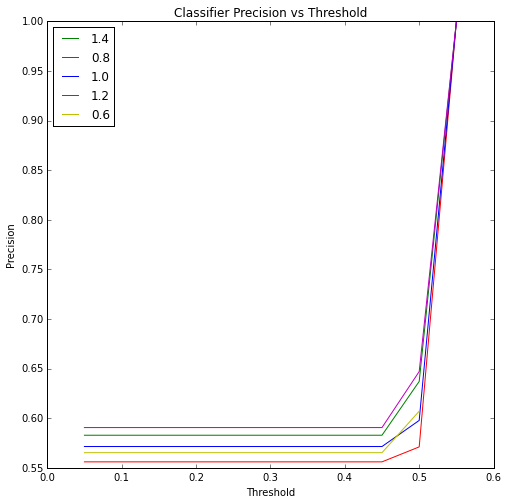

In [65]:
all_results = {}
n_feats = 500

for lr in [0.6, 0.8, 1.0, 1.2, 1.4]:
    print 'lr:', lr
    clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME',
                                              base_estimator=None, learning_rate=lr,
                                              n_estimators=40, random_state=None)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=100, seed=12345678)
    all_results['{}'.format(lr)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

1.2 delivers best result

###See how Adaboost reacts to feature reduction

In [73]:
clf = sklearn.ensemble.AdaBoostClassifier(algorithm='SAMME',
                                              base_estimator=None, learning_rate=1.2,
                                              n_estimators=40, random_state=None)

n_feats: 300
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 500
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 700
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 1000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 1500
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

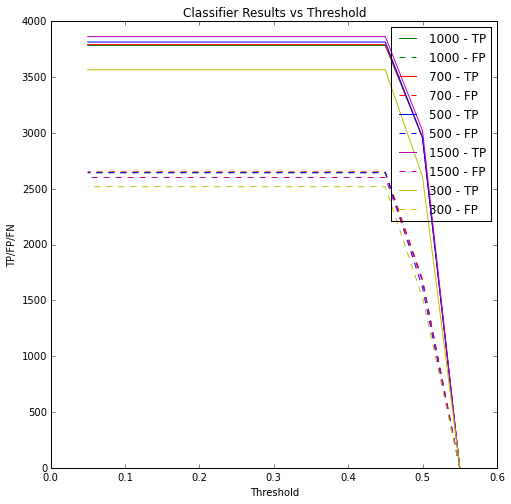

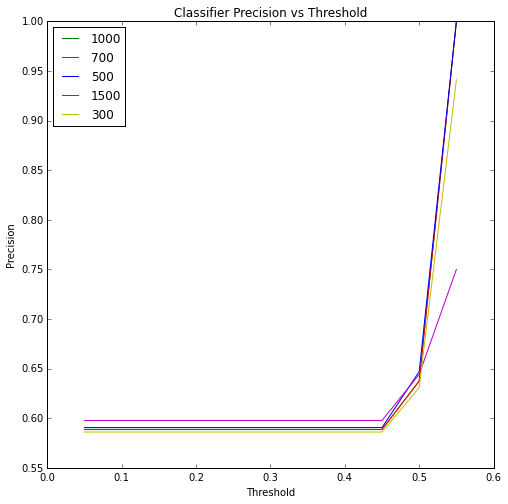

In [67]:
all_results = {}

for n_feats in [300, 500, 700, 1000, 1500]:
    print 'n_feats:', n_feats
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=100, seed=12345678)
    all_results[n_feats] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

n_feats: 1000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 2000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 3000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 4000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 5000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

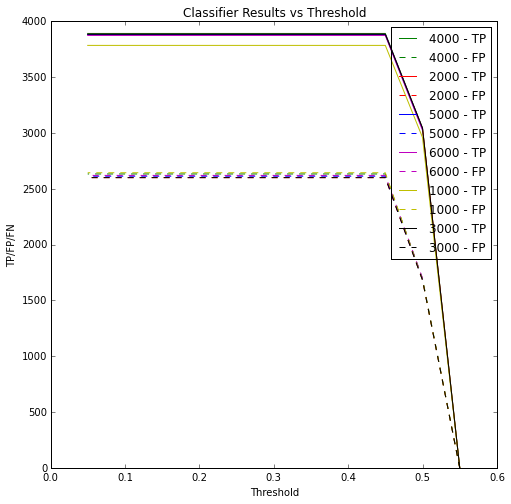

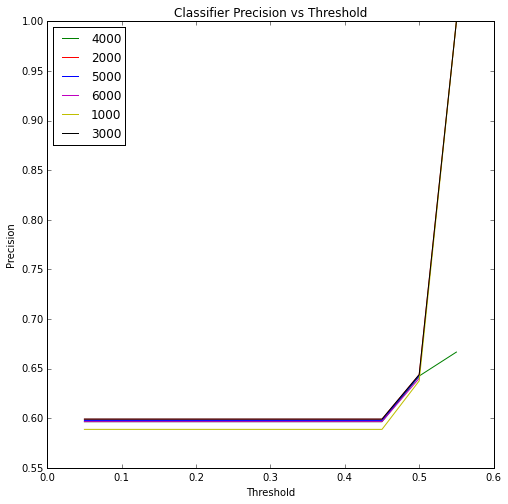

In [69]:
all_results = {}

for n_feats in [1000, 2000, 3000, 4000, 5000, 6000]:
    print 'n_feats:', n_feats
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=100, seed=12345678)
    all_results[n_feats] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

n_feats: 1000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 1300
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 1600
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
n_feats: 2000
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


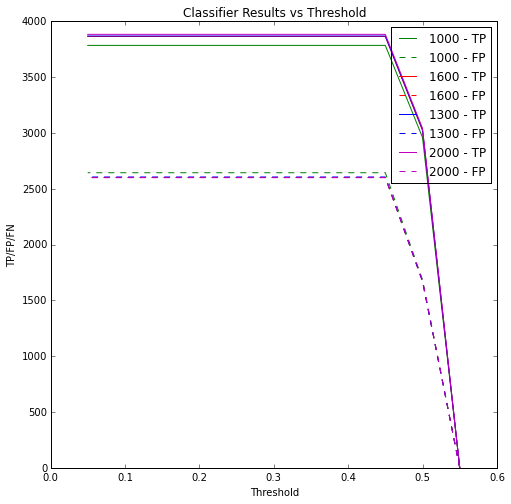

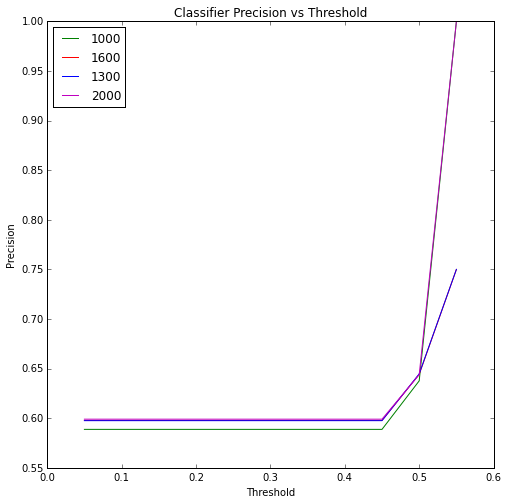

In [74]:
all_results = {}

for n_feats in [1000, 1300, 1600, 2000]:
    print 'n_feats:', n_feats
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=100, seed=12345678)
    all_results[n_feats] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

#Try SVC

c: 1.0
* * * * * * * * * *
c: 3.666
* * * * * * * * * *
c: 7.743
* * * * * * * * * *
c: 10.0
* * * * * * * * * *


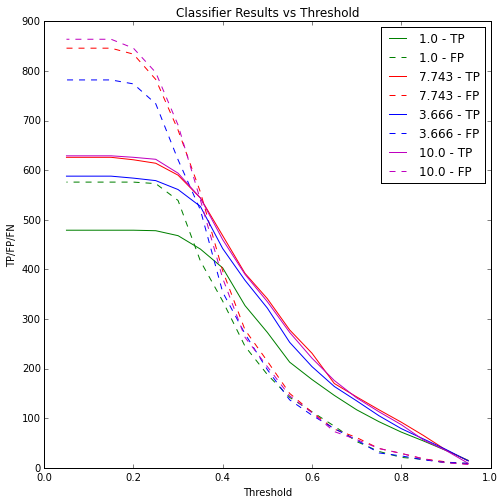

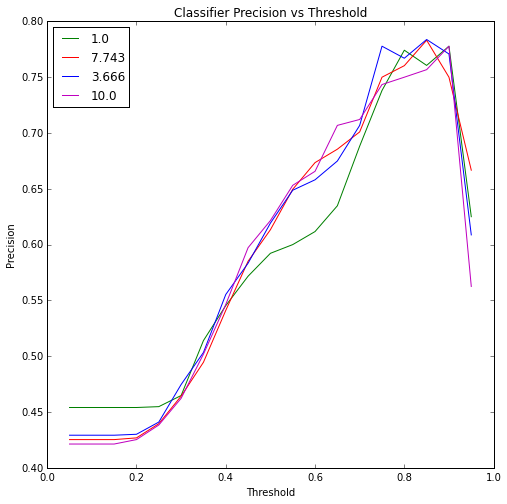

In [77]:
all_results = {}
n_feats = 500

for c in [1.0, 3.666, 7.743, 10.0]:
    print 'c:', c
    clf = SVC(C=c, cache_size=200, class_weight='auto', coef0=0.0,
              degree=3, gamma=0.0042813323987193957, kernel='rbf', max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001,
              verbose=False)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results['{}'.format(c)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

gamma: 0.0
* * * * * * * * * *
gamma: 0.001
* * * * * * * * * *
gamma: 0.0043
* * * * * * * * * *
gamma: 0.01
* * * * * * * * * *


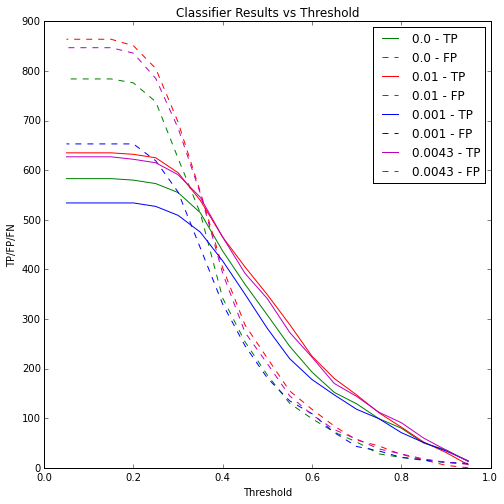

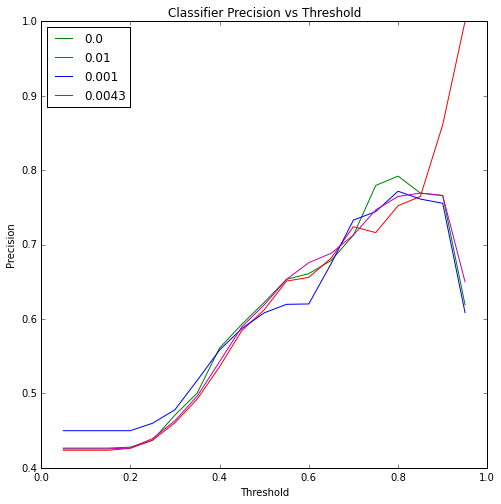

In [81]:
all_results = {}
n_feats = 500

for gamma in [0.0, 0.001, 0.0043, 0.01]:
    print 'gamma:', gamma
    clf = SVC(C=7.743, cache_size=200, class_weight='auto', coef0=0.0,
              degree=3, gamma=gamma, kernel='rbf', max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001,
              verbose=False)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results['{}'.format(gamma)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)

kernel: rbf
* * * * * * * * * *
kernel: linear
* * * * * * * * * *
kernel: sigmoid
* * * * * * * * * *


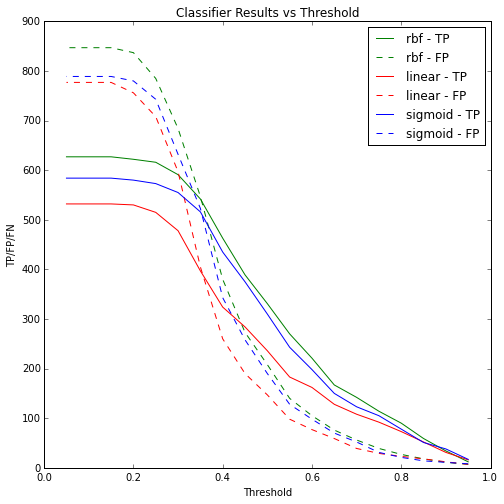

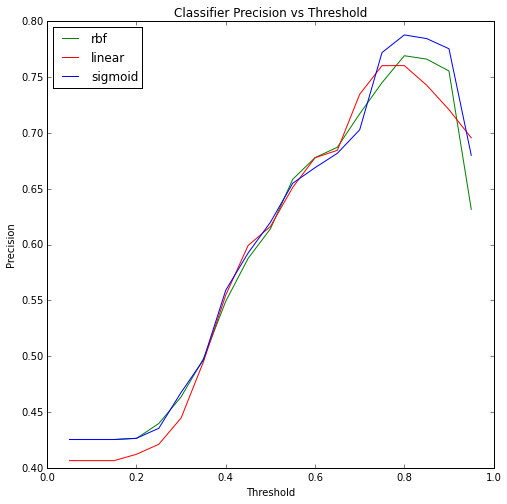

In [83]:
all_results = {}
n_feats = 500

for kernel in ['rbf','linear','sigmoid']:
    print 'kernel:', kernel
    clf = SVC(C=7.743, cache_size=200, class_weight='auto', coef0=0.0,
              degree=3, gamma=0.0043, kernel=kernel, max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001,
              verbose=False)
    
    results = getClassifierProbs(clf,
                                 SelectKBest(chi2, k=n_feats).fit_transform(scaler.fit_transform(X), Y),
                                 Y, history=2000, future=500, n_iter=10, seed=12345678)
    all_results['{}'.format(kernel)] = results
    print
    sys.stdout.flush()
plotCombinedResults(all_results)